### Import libraries

In [64]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
# %pip install visualkeras
import visualkeras as vk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import os

## Prepare the data

In [97]:
# Model / data parameters
img_width, img_height = 28, 28
epochs = 23
batch_size = 64
input_shape = (28, 28, 1)
num_classes = 10

notMNIST_load_data is a function that loads the notMNIST dataset. It returns two tuples containing the training and test data. Each tuple is formed by a numpy array containing the images (values are between 0 and 1) and a numpy array containing the labels (0 to 9).

In [66]:
def notMNIST_load_data() : 
    data_dir_letters = 'data/notMNIST_small'

    nb_letters = len(os.listdir(data_dir_letters))
    if nb_letters != num_classes:
        raise ValueError('The number of classes is not equal to the number of letters in the folder')

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    # we get the number of samples in the smallest class
    min_nb_samples = float('inf')
    for letter in os.listdir(data_dir_letters):
        nb_samples = len(os.listdir(os.path.join(data_dir_letters, letter)))
        min_nb_samples = min(min_nb_samples, nb_samples)

    # 80% of the data is used for training
    # 20% for testing
    nb_train_samples = int(min_nb_samples * 0.8)
    nb_test_samples = nb_samples - nb_train_samples

    # for each letter folder, we copy the images in the train, validation or test tuple and the label
    for letter in os.listdir(data_dir_letters):
        index = 0

        for image in glob.iglob(os.path.join(data_dir_letters, letter, "*.png")):

            if index < nb_train_samples:
                pixels_array = mpimg.imread(image)  # image to array, value between 0 and 1
                x_train.append(pixels_array)
                y_train.append(ord(letter) - 65)
            elif index < nb_train_samples + nb_test_samples:
                pixels_array = mpimg.imread(image)  # image to array, value between 0 and 1
                x_test.append(pixels_array)
                y_test.append(ord(letter) - 65)
            index += 1
    
    return (np.array(x_train), np.array(y_train)), (np.array(x_test), np.array(y_test))

In [67]:
# load the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = notMNIST_load_data()

In [70]:
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (14970, 28, 28, 1)
14970 train samples
3750 test samples


In [71]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Build the model

We build different models to find the best architecture for ouf classification problem.

In [ ]:
def build_old_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Conv2D(32, (3, 3), padding='same'))
    # model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # addind a dropout layer to avoid overfitting
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(units=64, activation='relu'))
    # addind a dropout layer to avoid overfitting
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def build_model_LeNet():
    # LeNet-5 architecture
    model = Sequential()
    
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

In [ ]:
def build_model_LeNet_new():
    # LeNet-5 architecture
    model = Sequential()
    
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=120, activation='tanh'))
    model.add(Dense(units=84, activation='tanh'))
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

In [75]:
def build_model_LeNet_best():
    # LeNet-5 architecture found in a paper
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(strides=2))

    model.add(Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(strides=2))

    model.add(Flatten())

    # addind a dropout layer to avoid overfitting
    model.add(Dropout(rate=0.25))

    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=84, activation='relu'))

    # addind a dropout layer to avoid overfitting
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

In [105]:
# get the model
model = build_model_LeNet_best()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 1200)              0         
                                                                 
 dropout_8 (Dropout)         (None, 1200)             

### Visualize the model

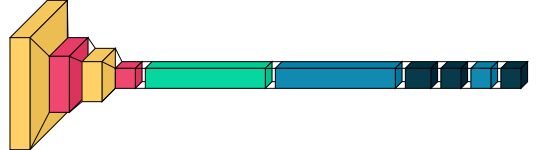

In [106]:
vk.layered_view(model)

## Train the model

### With k-fold cross validation

In [107]:
# Parameters and results
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

We perform a k-fold cross validation to train different models and find the best one. We use the accuracy as a metric to compare the models. For each fold, we split the training data into a training set and a validation set.

In [108]:
def train_model_on_kfold(model, kfold, X_train, y_train):
    best_model = None
    best_val_accuracy = 0.0
    history = None

    for fold_index, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
        print(f'Fold #{fold_index + 1}')
        
        # Split the train data into train and validation sets for this fold
        X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
        y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

        # Compile and fit the model for this fold
        model.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        history = model.fit(
            X_train_fold, 
            y_train_fold, 
            epochs=epochs, 
            batch_size=batch_size, 
            steps_per_epoch=len(X_train_fold) // batch_size, 
            validation_data=(X_val_fold, y_val_fold),
            workers=16,
            use_multiprocessing=True
        )
        
        # Evaluate the model on the validation data for this fold
        scores = model.evaluate(X_val_fold, y_val_fold)
        val_accuracy = scores[1]
        print(f'Validation Accuracy: {val_accuracy*100:.2f}%')
        
        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = keras.models.clone_model(model)
            best_model.set_weights(model.get_weights())

    return best_model, history

In [2]:
# Find the best model
best_model, history = train_model_on_kfold(model, kfold, x_train, y_train)

## Evaluate the trained model

In [110]:
# We compile the best model
best_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [111]:
# We test the best model on the test set
score = best_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

59/59 [==============================] - 1s 7ms/step - loss: 0.2175 - accuracy: 0.9312
Test loss: 0.21748313307762146
Test accuracy: 0.9312000274658203


In [91]:
# Perform Prediction
y_pred = model.predict(x_test)

118/118 [==============================] - 1s 7ms/step


### Show Confusion Matrix and accuracy evoluation

In [92]:
# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, nb_classes):
    classes = np.arange(nb_classes)
    classes_print = [chr(i) for i in range(65, 65 + nb_classes)]
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes_print, columns=classes_print)

    plt.figure(1, figsize=(16, 8))
    sns.set(font_scale=1.5, color_codes=True, palette='deep')
    sns.heatmap(cm_df, annot=True, annot_kws={'size': 16}, fmt='d', cmap='YlGnBu')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title('Confusion Matrix')
    plt.show()

In [93]:
# Plotting Train and Validation Loss
def plot_errors(history, epochs):
    epochs_range = list(range(1, epochs + 1))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_loss, label='train_loss')
    plt.plot(epochs_range, val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

In [120]:
# Plotting Train and Validation Accuracy
def plot_accurary(history, epochs):
    epochs_range = list(range(1, epochs + 1))
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(1, figsize=(10, 6))
    plt.plot(epochs_range, train_accuracy, label='train_accuracy')
    plt.plot(epochs_range, val_accuracy, label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

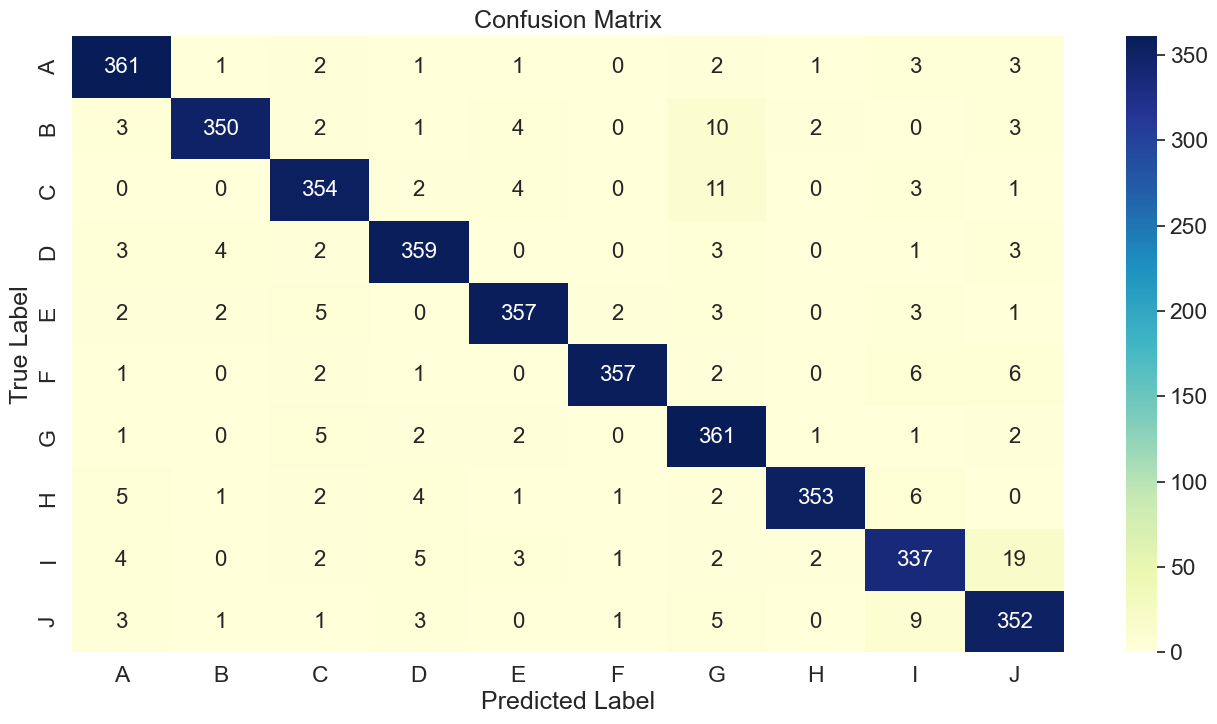

In [95]:
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), 10)

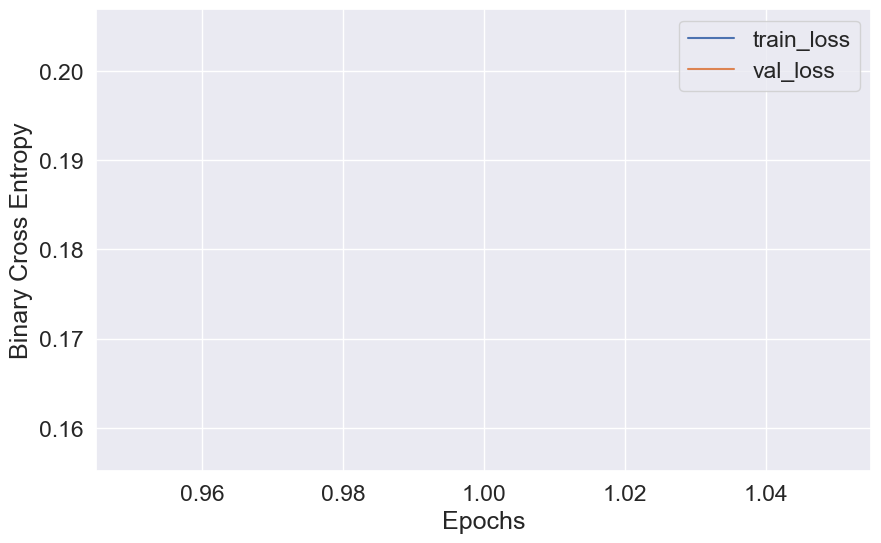

In [112]:
plot_errors(history, epochs)

[1]


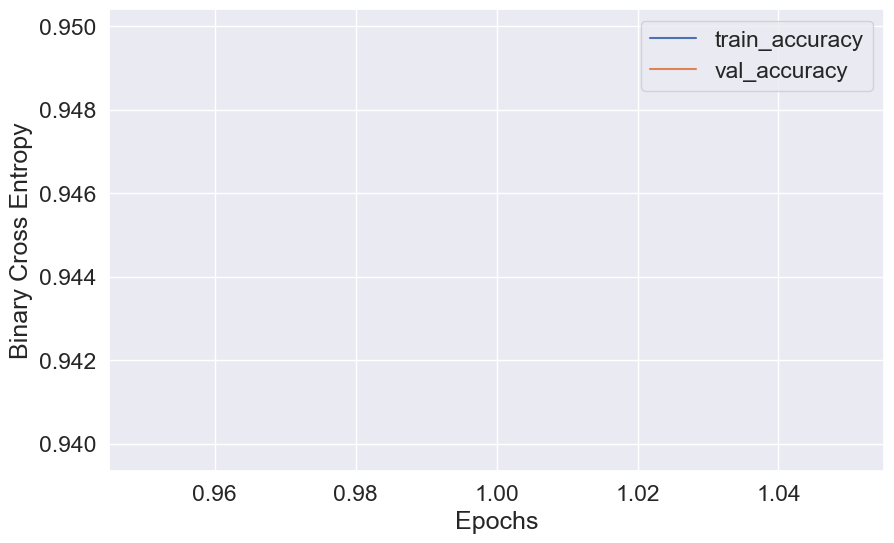

In [119]:
plot_accurary(history, epochs)

### Results - used to find the best architecture and hyperparameters
* Architecture LeNet-5 \
50 epochs, batch size 128 \
Epoch 50/50 - loss: 0.3308 - accuracy: 0.8945 \
Test loss: 2.313185691833496 \
Test accuracy: 0.649066686630249 \

* Architecture LeNet-5 \
15 epochs, batch size 16 \
Epoch 15/15 - loss: 0.4077 - accuracy: 0.8687 \
Test loss: 2.001655101776123 \
Test accuracy: 0.7760000228881836 \

* Architecture LeNet-5 \
15 epochs, batch size 16 \
Convolution : kernel_size=(5, 5), activation='relu' \
Epoch 15/15 - loss: 0.2376 - accuracy: 0.9270 \
Test loss: 1.7583626508712769 \
Test accuracy: 0.8191999793052673 \

* Architecture LeNet-5_new \
15 epochs, batch size 16 \
Convolution : kernel_size=(5, 5), activation='tanh' \
Pooling : pool_size=(2, 2), strides=(2, 2) \
Epoch 15/15 - loss: 0.2376 - accuracy: 0.9270 \
Test loss: 1.7583626508712769   \
Test accuracy: 0.8191999793052673 \

* Architecture LeNet-5_best (from paper)  \
30 epochs, batch size 16, steps_per_epoch=len(x_train) // batch_size \
Epoch 30/30 - loss: 0.0706 - accuracy: 0.9753 \
Test loss: 0.47975218296051025 \
Test accuracy: 0.909333348274231 \

* Architecture LeNet-5_best (from paper) with data augmentation \
30 epochs, batch size 100, steps_per_epoch=len(x_train) // 100 \
Epoch 30/30 - loss: 0.2406 - accuracy: 0.9232 \
Test loss: 0.24029511213302612  \
Test accuracy: 0.9306666851043701 \

* Architecture LeNet-5_best (from paper) with data augmentation and validation \
30 epochs, batch size 100, steps_per_epoch=len(x_train) // 100 \
Epoch 30/30 - loss: 0.2584 - accuracy: 0.9195 \
Test loss: 0.22855401039123535  \
Test accuracy: 0.9293333292007446 \

* Architecture LeNet-5_best (from paper) with dropout layers, using multiprocessing \
24 epochs, batch size 64, steps_per_epoch=len(x_train) // batch_size \
Epoch 24/24 - loss: 0.0342 - accuracy: 0.9882 \
Test loss: 0.31037890911102295 \
Test accuracy: 0.9498666524887085 \

### Papers :
https://www.kaggle.com/code/curiousprogrammer/lenet-5-cnn-with-keras-99-48 \
https://patilswaraj22.medium.com/keras-based-implementation-of-lenet-5-db678b11c61a (For the confusion matrix and error/accuracy evaluation)